In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys, re, pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import dask
import dask.dataframe as dd
import dask.array as da
from shapely import wkt
import seaborn as sns
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from pygris import tracts
from sklearn.model_selection import train_test_split

# Process each county

In [2]:
from dask.distributed import Client
client = Client(n_workers=40)  # Start a local Dask cluster. You can also connect to an existing Dask cluster.

2023-04-23 21:53:32,169 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-n2yem6_j', purging
2023-04-23 21:53:32,170 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-klh9kheo', purging
2023-04-23 21:53:32,170 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-1xsfbb2o', purging
2023-04-23 21:53:32,170 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7purobdn', purging
2023-04-23 21:53:32,170 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-pnl7ut5c', purging
2023-04-23 21:53:32,171 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-l_4g1z72', purging
2023-04-23 21:53:32,171 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_t21458x', purging

## Table 1.a: census tract polygon table

In [3]:
def get_poly_df(state: str, counties: str, year=2019):
    poly_df = tracts(state=state, county=counties, cb=False, year=year)[['GEOID', 'geometry']]
    print(poly_df.crs)
    poly_df = poly_df.rename(columns={'GEOID': 'census_tract'})
    poly_df['centroid'] = poly_df['geometry'].centroid
    poly_df = poly_df.reset_index(drop=True)
    poly_df.to_csv(f'data/processed/{counties.split(" ")[0]}_poly.csv', index=False)

In [5]:
get_poly_df('TX', 'Harris County')

Using FIPS code '48' for input 'TX'
Using FIPS code '201' for input 'Harris County'
epsg:4269


In [6]:
get_poly_df('WA', 'King County')

Using FIPS code '53' for input 'WA'
Using FIPS code '033' for input 'King County'
epsg:4269


In [7]:
get_poly_df('MA', 'Suffolk County')

Using FIPS code '25' for input 'MA'
Using FIPS code '025' for input 'Suffolk County'
epsg:4269


In [5]:
def get_poly_dask_df(state: str, counties: str, year=2019, npartition=4) -> dd.core.DataFrame:
    poly_df = tracts(state=state, county=counties, cb=False, year=year)[['GEOID', 'geometry']]
    poly_df = poly_df.rename(columns={'GEOID': 'FIPS'})
    poly_df['geometry_wkt'] = poly_df['geometry'].to_wkt()
    poly_df = poly_df.drop('geometry', axis=1).reset_index(drop=True)
    poly_df = dd.from_pandas(poly_df, npartitions=npartition)
    return poly_df

## Table 1.b: census tract features table

In [6]:
def get_feature_dask_df_from_city(city_path, poly_df):
    city_feature_df = dd.read_csv(city_path)
    city_feature_df['FIPS'] = city_feature_df['FIPS'].astype(str)
    feature_df = poly_df.merge(city_feature_df, on='FIPS', how='left')
    return feature_df.drop(['LOCATION', 'streets_per_node_counts', 'streets_per_node_proportions', 'graph’s average node degree'], axis=1)

## Table 1.c: census tract population table

In [7]:
def get_census_tract_popul_df(path, feat_attr_df):
    popul_df = dd.read_csv(path).loc[1:][['GEO_ID', 'P2_001N']]
    popul_df = popul_df.rename(columns={'GEO_ID': 'FIPS', 'P2_001N': 'pop'})
    popul_df['pop'] = popul_df['pop'].astype(int)
    popul_df['FIPS'] = popul_df['FIPS'].apply(lambda x: x[-11:]).astype(str)
    feat_attr_pop_df = feat_attr_df.merge(popul_df, on='FIPS', how='left')
    return feat_attr_pop_df

## Table 1.d: census tract protected attribute table

In [8]:
def get_attr_dask_df_from_city(city_path, feature_df):
    city_attr_df = dd.read_csv(city_path)[['PCI', 'FIPS']]
    city_attr_df['FIPS'] = city_attr_df['FIPS'].astype(str)
    feature_attr_df = feature_df.merge(city_attr_df, on='FIPS', how='left')
    return feature_attr_df

## Table I: Individual summarized table

In [9]:
def get_summarized_ddf(state, city, county):
    poly_ddf = get_poly_dask_df(state, county)
    feature_ddf = get_feature_dask_df_from_city(f'data/processed/{city}_osm.csv', poly_ddf)
    feature_pop_ddf = get_census_tract_popul_df(f'data/processed/{county.split(" ")[0]}_popul.csv', feature_ddf)
    feature_pop_attr_ddf = get_attr_dask_df_from_city(f'data/processed/{city}_pci.csv', feature_pop_ddf).fillna(0)
    return feature_pop_attr_ddf

In [4]:
harris_feature_pop_attr_ddf = get_summarized_ddf('TX', 'Houston', 'Harris County')

Using FIPS code '48' for input 'TX'
Using FIPS code '201' for input 'Harris County'


In [43]:
king_feature_pop_attr_ddf = get_summarized_ddf('WA', 'Seattle', 'King County')

Using FIPS code '53' for input 'WA'
Using FIPS code '033' for input 'King County'


In [47]:
suffolk_feature_pop_attr_ddf = get_summarized_ddf('MA', 'Boston', 'Suffolk County')

Using FIPS code '25' for input 'MA'
Using FIPS code '025' for input 'Suffolk County'


## Table 2.a: census tract flow table

In [13]:
def get_county_ct_flow_dask_df(county_fips: str, days=14, npartitions=10) -> dd.core.DataFrame:  
    dir = 'data/raw/flow_files'
    folder = os.path.join(dir, county_fips)
    flow_dfs = [dd.read_csv(os.path.join(folder, f_name)) for f_name in os.listdir(folder) if f_name.endswith('.csv')]
    flow_df = dd.concat(flow_dfs[:days], axis=0)
    flow_df = flow_df.rename(columns={'Origin_ID': 'FIPS_i', 'Destination_ID': 'FIPS_j', 'Count': 'count'})
    flow_df = flow_df[['FIPS_i', 'FIPS_j', 'count']]
    # Only get ct to ct counts
    flow_df = flow_df.loc[(flow_df['FIPS_i'].astype(str).apply(len)==11) & (flow_df['FIPS_j'].astype(str).apply(len)==11)]
    flow_df = flow_df.groupby(['FIPS_i', 'FIPS_j']).agg({'count': 'sum'}).reset_index().dropna()
    flow_df[['FIPS_i', 'FIPS_j']] = flow_df[['FIPS_i', 'FIPS_j']].astype(str)

    # Add 0 flows as non-linearty
    unique_fips = flow_df[['FIPS_i', 'FIPS_j']].melt().drop_duplicates().drop('variable', axis=1).rename(columns={'value': 'FIPS'}).reset_index(drop=True)
    # Perform a Cartesian join on the unique FIPS codes to generate all possible combinations of FIPS_i and FIPS_j
    all_combinations = unique_fips.assign(key=1).merge(unique_fips.assign(key=1), on='key', suffixes=('_i', '_j')).drop('key', axis=1)
    merged_df = all_combinations.merge(flow_df, on=['FIPS_i', 'FIPS_j'], how='left').fillna(0)
    new_rows = merged_df[merged_df['count'] == 0]
    new_rows_sample = new_rows.sample(frac=0.25)
    flow_df_extended = flow_df.append(new_rows_sample).reset_index(drop=True)
    flow_df_extended = flow_df_extended.groupby(['FIPS_i', 'FIPS_j']).agg({'count': 'sum'}).reset_index().dropna()
    flow_df_extended = flow_df_extended.repartition(npartitions=npartitions)
    flow_df_extended = flow_df_extended.map_partitions(lambda df: df.sample(frac=1))

    return flow_df_extended.reset_index(drop=True)

## Table 2.b: + features + protected attributes + geometry_wkt

In [14]:
def merge_flow_df(ind_df, flow_df):
    merged_flow_i_df = flow_df.merge(ind_df, left_on='FIPS_i', right_on='FIPS', suffixes=('_', '_i')).drop('FIPS', axis=1)
    merged_flow_ij_df = merged_flow_i_df.merge(ind_df, left_on='FIPS_j', right_on='FIPS', suffixes=('_i', '_j')).drop('FIPS', axis=1)
    return merged_flow_ij_df

## Table 2.c: + distance

In [15]:
def compute_distance(geometry_wkt_i, geometry_wkt_j):
    geom_i = wkt.loads(geometry_wkt_i)
    geom_j = wkt.loads(geometry_wkt_j)

    centroid_i = geom_i.centroid
    centroid_j = geom_j.centroid

    return geodesic((centroid_i.y, centroid_i.x), (centroid_j.y, centroid_j.x)).kilometers

def apply_distance(row):
    return compute_distance(row['geometry_wkt_i'], row['geometry_wkt_j'])

def compute_distance_dask_df(df: dd.DataFrame, npartitions: int = 10) -> dd.DataFrame:
    def apply_distance(row):
        return compute_distance(row['geometry_wkt_i'], row['geometry_wkt_j'])

    # Repartition the dataframe using the specified number of partitions
    df = df.repartition(npartitions=npartitions)

    # Compute the distance using map_partitions
    df['distance'] = df.map_partitions(lambda df: df.apply(apply_distance, axis=1), meta=('distance', 'f8'))

    return df

## Table 2.d: + income diff

In [16]:
def add_income_diff(feat_flow_ddf):
    feat_flow_ddf['income_diff'] = feat_flow_ddf.apply(lambda row: abs(row['PCI_i'] - row['PCI_j']), axis=1)
    income_range = feat_flow_ddf['income_diff'].max().compute() - feat_flow_ddf['income_diff'].min().compute()
    income_range /= 5
    def categorize_income_diff(income_diff):
        return 0 if income_diff < income_range else (1 if income_diff < 2 * income_range else 2)
    feat_flow_ddf['income_diff'] = feat_flow_ddf['income_diff'].map_partitions(lambda s: s.apply(categorize_income_diff), meta=('income_diff', 'i8'))
    return feat_flow_ddf

## Table II: Summarized flow table

In [17]:
def get_summarized_flow_df(fips_code, feat_pop_attr_ddf):
    flow_ddf = get_county_ct_flow_dask_df(fips_code)
    feat_flow_ddf = merge_flow_df(feat_pop_attr_ddf, flow_ddf)
    feat_flow_ddf['distance'] = feat_flow_ddf.map_partitions(lambda df: df.apply(apply_distance, axis=1), meta=('distance', 'f8'))
    feat_flow_ddf = compute_distance_dask_df(feat_flow_ddf)
    feat_flow_ddf = add_income_diff(feat_flow_ddf)
    count = feat_flow_ddf['count']
    feat_flow_ddf = feat_flow_ddf.drop(['geometry_wkt_i', 'geometry_wkt_j', 'count'], axis=1)
    feat_flow_ddf['count'] = count
    feat_flow_df = feat_flow_ddf.compute()
    return feat_flow_df
    

In [44]:
king_feat_flow_df = get_summarized_flow_df('53033', king_feature_pop_attr_ddf)

In [45]:
king_feat_flow_df

,FIPS_i,FIPS_j,Restaurants_i,"School, Colleges_i",Public Transport_i,Office_i,leisure_i,"Medical, Health_i",Residence_i,Commercial_landuse_i,...,self_loop_proportion_j,node_density_km_j,intersection_density_km_j,edge_density_km_j,street_density_km_j,pop_j,PCI_j,distance,income_diff,count
0,53033024702,53033005301,0.0,2.0,11.0,1.0,34.0,0.0,300.0,2.347045e+07,...,0.001487,4.064982e+09,3.731396e+09,3.309841e+11,1.799777e+11,0.0,15432.0,16.916607,2,6.0
1,53033031904,53033005301,0.0,0.0,2.0,0.0,23.0,0.0,6.0,1.893151e+04,...,0.001487,4.064982e+09,3.731396e+09,3.309841e+11,1.799777e+11,0.0,15432.0,28.865994,1,0.0
2,53033000402,53033005301,0.0,0.0,16.0,0.0,1.0,0.0,60.0,1.786140e+08,...,0.001487,4.064982e+09,3.731396e+09,3.309841e+11,1.799777e+11,0.0,15432.0,6.823318,1,14.0
3,53033005301,53033005301,3.0,0.0,46.0,6.0,15.0,1.0,14.0,1.069586e+08,...,0.001487,4.064982e+09,3.731396e+09,3.309841e+11,1.799777e+11,0.0,15432.0,0.000000,0,1518.0
4,53033029203,53033005301,2.0,4.0,51.0,49.0,39.0,3.0,15.0,4.151586e+09,...,0.001487,4.064982e+09,3.731396e+09,3.309841e+11,1.799777e+11,0.0,15432.0,31.213071,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10323,53033031400,53033020100,3.0,1.0,3.0,82.0,41.0,5.0,0.0,4.280193e+08,...,0.005445,6.467526e+08,4.546334e+08,9.134820e+10,4.638339e+10,3335.0,64141.0,69.533857,1,0.0
10324,53033032319,53033020100,1.0,0.0,36.0,17.0,18.0,2.0,20.0,4.478614e+09,...,0.005445,6.467526e+08,4.546334e+08,9.134820e+10,4.638339e+10,3335.0,64141.0,18.007639,0,1.0
10325,53033031502,53033020100,0.0,0.0,0.0,3.0,44.0,0.0,0.0,2.909861e+06,...,0.005445,6.467526e+08,4.546334e+08,9.134820e+10,4.638339e+10,3335.0,64141.0,81.984290,0,0.0
10326,53033020100,53033020100,0.0,0.0,5.0,1.0,38.0,1.0,0.0,4.049051e+08,...,0.005445,6.467526e+08,4.546334e+08,9.134820e+10,4.638339e+10,3335.0,64141.0,0.000000,0,747.0


In [46]:
king_feat_flow_df.to_parquet(os.path.join('data/processed', 'King_feat.parquet'), index=False)

In [48]:
suffolk_feat_flow_df = get_summarized_flow_df('25025', suffolk_feature_pop_attr_ddf)

In [49]:
suffolk_feat_flow_df

,FIPS_i,FIPS_j,Restaurants_i,"School, Colleges_i",Public Transport_i,Office_i,leisure_i,"Medical, Health_i",Residence_i,Commercial_landuse_i,...,self_loop_proportion_j,node_density_km_j,intersection_density_km_j,edge_density_km_j,street_density_km_j,pop_j,PCI_j,distance,income_diff,count
0,25025091600,25025091600,0,1,8,2,5,0,0,5.799055e+08,...,0.010638,6.037502e+08,5.375858e+08,8.751088e+10,5.363315e+10,3200.0,23727.0,0.000000,0,486.0
1,25025030200,25025091600,0,0,0,0,3,0,0,0.000000e+00,...,0.010638,6.037502e+08,5.375858e+08,8.751088e+10,5.363315e+10,3200.0,23727.0,6.506039,1,0.0
2,25025110501,25025091600,0,1,5,0,0,0,0,0.000000e+00,...,0.010638,6.037502e+08,5.375858e+08,8.751088e+10,5.363315e+10,3200.0,23727.0,7.130103,0,0.0
3,25025050300,25025091600,0,1,7,2,25,0,0,8.689272e+08,...,0.010638,6.037502e+08,5.375858e+08,8.751088e+10,5.363315e+10,3200.0,23727.0,7.518970,0,1.0
4,25025160502,25025091600,0,1,17,1,6,0,0,1.964531e+09,...,0.010638,6.037502e+08,5.375858e+08,8.751088e+10,5.363315e+10,3200.0,23727.0,10.576782,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,25025040300,25025051000,0,2,7,0,7,1,0,3.532533e+08,...,0.000000,9.519467e+08,8.230373e+08,1.209052e+11,7.204175e+10,4317.0,35697.0,4.037500,1,2.0
5230,25025981501,25025051000,0,0,3,1,61,0,0,1.339003e+08,...,0.000000,9.519467e+08,8.230373e+08,1.209052e+11,7.204175e+10,4317.0,35697.0,8.025455,1,0.0
5231,25025130402,25025051000,0,0,36,3,13,0,11,3.083906e+09,...,0.000000,9.519467e+08,8.230373e+08,1.209052e+11,7.204175e+10,4317.0,35697.0,17.942599,0,0.0
5232,25025091100,25025051000,0,3,6,1,1,0,10,9.361539e+07,...,0.000000,9.519467e+08,8.230373e+08,1.209052e+11,7.204175e+10,4317.0,35697.0,8.605919,0,2.0


In [51]:
suffolk_feat_flow_df.to_parquet(os.path.join('data/processed', 'Suffolk_feat.parquet'), index=False)

# Aggregate all the data

In [3]:
processed_folder = 'data/processed'
feat_paths = [os.path.join(processed_folder, f) for f in os.listdir(processed_folder) if f.endswith('_feat.parquet')]
feat_paths

['data/processed/Atlanta_feat.parquet',
 'data/processed/Harris_feat.parquet',
 'data/processed/King_feat.parquet',
 'data/processed/Suffolk_feat.parquet']

In [4]:
df_dict = {re.search(r"/([^/]+)_feat", feat_path).group(1): pd.read_parquet(feat_path) for feat_path in feat_paths}

## Stat visualization

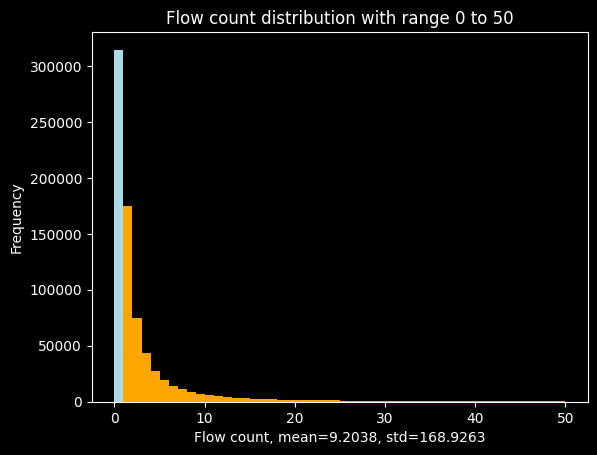

In [5]:
# Display the histogram of count of all the dfs
data = pd.concat(df_dict.values(), axis=0)['count']

# Create the histogram bins
bins = np.linspace(data.min(), 50, 51)

# Identify the indices of the bins containing x=0
zero_bin_indices = np.where((bins[:-1] <= 0) & (bins[1:] > 0))[0]

# Create a histogram
hist, edges = np.histogram(data, bins)

# Set up the figure and axis
fig, ax = plt.subplots()

# Plot the histogram bars
for i, (freq, left_edge) in enumerate(zip(hist, edges[:-1])):
    if i in zero_bin_indices:
        color = 'lightblue'  # Highlight x=0 bar(s) with yellow color
    else:
        color = 'orange'  # Use light blue color for other bars
    ax.bar(left_edge, freq, width=np.diff(edges)[0], color=color, align='edge')

# Set axis labels
ax.set_xlabel(f"Flow count, mean={np.round_(data.mean(), 4)}, std={np.round_(data.std(), 4)}")
ax.set_ylabel('Frequency')

# Set plot title
ax.set_title('Flow count distribution with range 0 to 50')

# Display the histogram
plt.show()


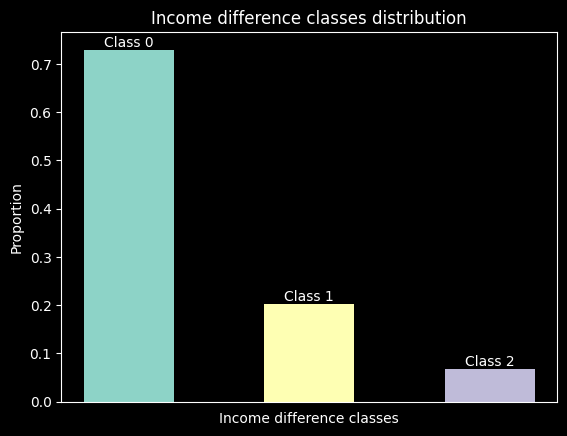

In [154]:
# Display the histogram of income difference classes
data = pd.concat(df_dict.values(), axis=0)['income_diff']

# Set the number of bins
n_bins = 3

# Create the histogram bins
bins = np.linspace(data.min(), data.max(), n_bins+1)

# Create a histogram
hist, edges = np.histogram(data, bins)

# Set up the figure and axis
fig, ax = plt.subplots()

# Define the width of bars and gaps
bar_width = 0.5 * (edges[1] - edges[0])  # 50% of the original width

# Plot the histogram bars
for idx, (freq, left_edge) in enumerate(zip(hist, edges[:-1])):
    bar = ax.bar(left_edge, freq/len(data), width=bar_width, align='edge')
    ax.text(
        bar[0].get_x() + bar[0].get_width() / 2,
        bar[0].get_height(),
        f'Class {str(idx)}',
        ha='center',
        va='bottom'
    )

# Set axis labels
ax.set_xlabel('Income difference classes')
ax.set_ylabel('Proportion')
ax.set_xticks([])
ax.set_title('Income difference classes distribution')

# Display the histogram
plt.show()

## Data Processing

In [155]:
# Stack train and val df and remove outliers with count > 50
# The vals in df_dict are all test df

processed_df_dict = {}
main_train_df = pd.DataFrame()
main_val_df = pd.DataFrame()
test_dict = {}

for key, df in df_dict.items():
    
    df = df[df['count'] <= 50]
    
    train_df, temp_df = train_test_split(df, test_size=0.4, shuffle=True, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)
    
    if main_train_df.empty:
        main_train_df = train_df
    else:
        main_train_df = pd.concat([main_train_df, train_df], axis=0)
    if main_val_df.empty:
        main_val_df = val_df
    else:
        main_val_df = pd.concat([main_val_df, val_df], axis=0)
    
    test_dict[key] = test_df

processed_df_dict['train_df'] = main_train_df
processed_df_dict['val_df'] = main_val_df
processed_df_dict['test_dict'] = test_dict


In [156]:
with open('data/processed/df_dict.pkl', 'wb') as f:
    pickle.dump(processed_df_dict, f)

In [157]:
with open('data/processed/df_dict.pkl', 'rb') as f:
    processed_df_dict = pickle.load(f)

In [158]:
processed_df_dict['test_dict'].keys()

dict_keys(['Atlanta', 'Harris', 'King', 'Suffolk'])